[write_ups](https://github.com/tamzeed-toha/Nonlinear_and_Data_Driven_Estimation/blob/main/write_ups/project_write_ups.pdf)

# Nonlinear observability and estimation


this notebook contains non-linear observability analysis of my model. which is a planer drone with unknown control parameters. then with an observable model, different estimation techniques are applied to estimate the unknown parameters.

In [1]:
import numpy as np
import sympy as sp
import sys
import matplotlib.pyplot as plt
from pprint import pprint
import scipy
from scipy.integrate import odeint
import matplotlib.colors as mcolors

sys.path.append('../Utility')
import symbolic_derivatives
from plot_utility import plot_tme
from emperical_observability import empirical_observability_matrix

sp.init_printing()

%load_ext autoreload
%autoreload 2

# Observability analysis of the model

## states and dynamics

In [2]:
theta_dot, theta, x_dot, x, z_dot, z, beta1, beta2, beta3 = sp.symbols(r'\dot{\theta} theta \dot{x} x \dot{z} z beta1 beta2 beta3')
g = sp.symbols('g')

state = sp.Matrix([theta_dot, theta, x_dot, x, z_dot, z, beta1, beta2, beta3])

f_0 = sp.Matrix([0, theta_dot, 0, x_dot, -g, z_dot, 0, 0, 0])
f_1 = sp.Matrix([0, 0, beta2, 0, beta3, 0, 0, 0, 0])
f_2 = sp.Matrix([beta1, 0, 0, 0, 0, 0, 0, 0, 0])

state, f_0, f_1, f_2

⎛⎡\dot{\theta}⎤  ⎡     0      ⎤  ⎡0 ⎤  ⎡β₁⎤⎞
⎜⎢            ⎥  ⎢            ⎥  ⎢  ⎥  ⎢  ⎥⎟
⎜⎢     θ      ⎥  ⎢\dot{\theta}⎥  ⎢0 ⎥  ⎢0 ⎥⎟
⎜⎢            ⎥  ⎢            ⎥  ⎢  ⎥  ⎢  ⎥⎟
⎜⎢  \dot{x}   ⎥  ⎢     0      ⎥  ⎢β₂⎥  ⎢0 ⎥⎟
⎜⎢            ⎥  ⎢            ⎥  ⎢  ⎥  ⎢  ⎥⎟
⎜⎢     x      ⎥  ⎢  \dot{x}   ⎥  ⎢0 ⎥  ⎢0 ⎥⎟
⎜⎢            ⎥  ⎢            ⎥  ⎢  ⎥  ⎢  ⎥⎟
⎜⎢  \dot{z}   ⎥, ⎢     -g     ⎥, ⎢β₃⎥, ⎢0 ⎥⎟
⎜⎢            ⎥  ⎢            ⎥  ⎢  ⎥  ⎢  ⎥⎟
⎜⎢     z      ⎥  ⎢  \dot{z}   ⎥  ⎢0 ⎥  ⎢0 ⎥⎟
⎜⎢            ⎥  ⎢            ⎥  ⎢  ⎥  ⎢  ⎥⎟
⎜⎢     β₁     ⎥  ⎢     0      ⎥  ⎢0 ⎥  ⎢0 ⎥⎟
⎜⎢            ⎥  ⎢            ⎥  ⎢  ⎥  ⎢  ⎥⎟
⎜⎢     β₂     ⎥  ⎢     0      ⎥  ⎢0 ⎥  ⎢0 ⎥⎟
⎜⎢            ⎥  ⎢            ⎥  ⎢  ⎥  ⎢  ⎥⎟
⎝⎣     β₃     ⎦  ⎣     0      ⎦  ⎣0 ⎦  ⎣0 ⎦⎠

## measurements:

In [3]:
h0 = state                  # essentially all states are directly measured
h1 = sp.Matrix([theta, x, z])  # only theta, x, and z are measured
h2 = sp.Matrix([theta, x])  # only theta and x are measured
h3 = sp.Matrix([theta*x*z])  # only theta and z are measured
h4 = sp.Matrix([theta, x*z])      # only x and z are measured
h5 = sp.Matrix([theta, x+z, z])  # theta, x+z, and z are measured
h6 = sp.Matrix([theta+x, z+x])  # theta+x, z+x, and z are measured 
h7 = sp.Matrix([theta+x, x+z, z+theta])  # theta+x, x+z, and z+theta are measured
h8 = sp.Matrix([theta*x, z/x, theta+z])  # theta*x, z/x, and theta+z are measured
h9 = sp.Matrix([theta*x, z/x,])  # theta*x, z/x, and theta+z are measured\

h_collection = [h0, h1, h2, h3, h4, h5, h6, h7, h8, h9]
h_collection

⎡⎡\dot{\theta}⎤                                                               
⎢⎢            ⎥                                                               
⎢⎢     θ      ⎥                                                               
⎢⎢            ⎥                                                               
⎢⎢  \dot{x}   ⎥                                                               
⎢⎢            ⎥                                                       ⎡ θ⋅x ⎤ 
⎢⎢     x      ⎥  ⎡θ⎤                       ⎡  θ  ⎤           ⎡θ + x⎤  ⎢     ⎥ 
⎢⎢            ⎥  ⎢ ⎥  ⎡θ⎤           ⎡ θ ⎤  ⎢     ⎥  ⎡θ + x⎤  ⎢     ⎥  ⎢  z  ⎥ 
⎢⎢  \dot{z}   ⎥, ⎢x⎥, ⎢ ⎥, [θ⋅x⋅z], ⎢   ⎥, ⎢x + z⎥, ⎢     ⎥, ⎢x + z⎥, ⎢  ─  ⎥,
⎢⎢            ⎥  ⎢ ⎥  ⎣x⎦           ⎣x⋅z⎦  ⎢     ⎥  ⎣x + z⎦  ⎢     ⎥  ⎢  x  ⎥ 
⎢⎢     z      ⎥  ⎣z⎦                       ⎣  z  ⎦           ⎣θ + z⎦  ⎢     ⎥ 
⎢⎢            ⎥                                                       ⎣θ + z⎦ 
⎢⎢     β₁     ⎥                                     

## G and O matrix

In [4]:

g_first_order = []
G_collection = []
O_collection = []
first_order_bigO = []
for h in h_collection:
    g1 = symbolic_derivatives.get_bigO(h, state, [f_0, f_1, f_2])
    g2 = symbolic_derivatives.get_bigO(sp.Matrix.vstack(*g1), state, [f_0, f_1, f_2])
    # take only unique rows
    g1 = set(sp.Matrix.vstack(*g1))
    g2 = set(sp.Matrix.vstack(*g2))

    G = sp.Matrix(list(g1.union(g2)))    
    g1 = sp.Matrix(list(g1))   ## for comparing first order and second orders
    O = G.jacobian(state)
    
    g_first_order.append(g1)
    G_collection.append(G)
    O_collection.append(O)
    first_order_bigO.append(g1.jacobian(state))

G_collection

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢⎡     0      ⎤  ⎡     0      ⎤                                               
⎢⎢            ⎥  ⎢            ⎥                                               
⎢⎢     -g     ⎥  ⎢     -g     ⎥                     

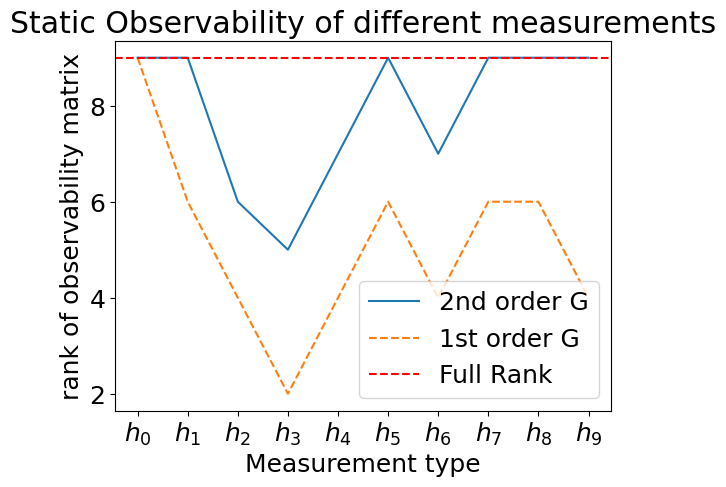

In [5]:
# check observability of every kind of measurement
ranks = [O.rank() for O in O_collection]
first_order_ranks = [O.rank() for O in first_order_bigO]
plt.plot(ranks, label="2nd order G")
plt.plot(first_order_ranks, label="1st order G", ls='--')
plt.axhline(y=state.shape[0], color='r', linestyle='--', label='Full Rank')
plt.xticks(range(len(h_collection)), labels=[r'$h_{}$'.format(i) for i in range(len(h_collection))] )
plt.legend()
plt.title('Static Observability of different measurements')
plt.ylabel('rank of observability matrix')
plt.xlabel('Measurement type')
plt.show()

obviously, the model is more observable when if we use second derivative of G.
\
\
generally, to make the model observable we need atleast 3 measurements (each for every degree of freedom).
\
\
but observability might also depend on state values. to check that we can use the above method on a simulated 2d drone model given a set of trajectories.

# data simulation

In [6]:
class planer_drone():
    def __init__(self):
        self.m = 0.5 # mass
        self.l = 0.2 # distance from rotor to COM
        self.I = 2/5*self.m*self.l**2 # Moment of inertia (Iyy) -- assuming drone is a sphere (it is not)
        self.g = 9.81 # gravity constant

        # Control Parameters
        self.tau_k_theta = 10 # torque control to stabilize theta
        self.tau_k_thetadot = 20 # torque control to provide thetadot damping
        self.tau_k_x = 0.01 # torque control to control x position
        self.tau_k_xdot = 0.2 # torque control to provide xdot damping
        self.F_k_z = 1000 # Force control to control z position
        self.F_k_zdot = 10000 # Force control to control z position
        self.F0 = self.m * self.g
        
    def control(self, X, t, desired_trajectory):
        thetadot, theta, xdot, x, zdot, z = np.ravel(X)
        
        # desired trajectory
        theta_des, x_des, z_des = desired_trajectory(t)
        
        # error
        x_err = x_des - x
        z_err = z_des - z
        
        # control
        tau = -(self.tau_k_x*x_err - self.tau_k_xdot*xdot)  + (self.tau_k_theta*(-theta) - self.tau_k_thetadot*thetadot)
        F = (self.F_k_z*z_err - self.F_k_zdot*zdot)
        
        return F, tau
    
    def f(self, X, t, desired_trajectory):
        thetadot, theta, xdot, x, zdot, z = np.ravel(X)
        
        # control
        F, tau = self.control(X, t, desired_trajectory)
        
        # dynamics
        d_theta = thetadot
        d_thetadot = tau/self.I
        d_x = xdot
        d_xdot = -F*np.sin(theta)/self.m
        d_z = zdot
        d_zdot = (F*np.cos(theta)-self.m*self.g)/self.m
        
        # d_x = [d_theta, d_thetadot, d_x, d_xdot, d_z, d_zdot]
        d_x = [d_thetadot, d_theta, d_xdot, d_x, d_zdot, d_z]
        
        return d_x
    
    def simulate(self, x0, tsim, desired_trajectory, h, state_symbolic):
        result = odeint(self.f, x0, tsim, args=(desired_trajectory,))
        x = result.T
        afunc = lambda i: h.subs(list(zip(state_symbolic, x[:,i])))
        y = np.array(list(map(afunc, range(x.shape[1])))).T
        y = np.atleast_2d(y)
        y = y.reshape(-1, y.shape[-1])
        return x, y

## trajectories

In [7]:
def sinusoidal_x(t):
    theta_des = 0*np.ones_like(t)
    z_des = 1*np.ones_like(t)
    x_des = np.sin(0.05*t)
    return theta_des, x_des, z_des

trajectories = {"sinusoidal_x" : sinusoidal_x}

## running the simulation:

In [8]:
time = np.arange(0, 1000, 0.1)
drone = planer_drone()

simulated_states = {}
for trajectory_name, trajectory in trajectories.items():
    xx0 = np.random.rand(6)
    print(f"==>> initial condition: {xx0}")
    result = odeint(drone.f, xx0, time, args=(trajectory,))
    simulated_states[trajectory_name] = result.T

==>> initial condition: [0.93607339 0.94074384 0.95403167 0.9702241  0.57034881 0.30649613]


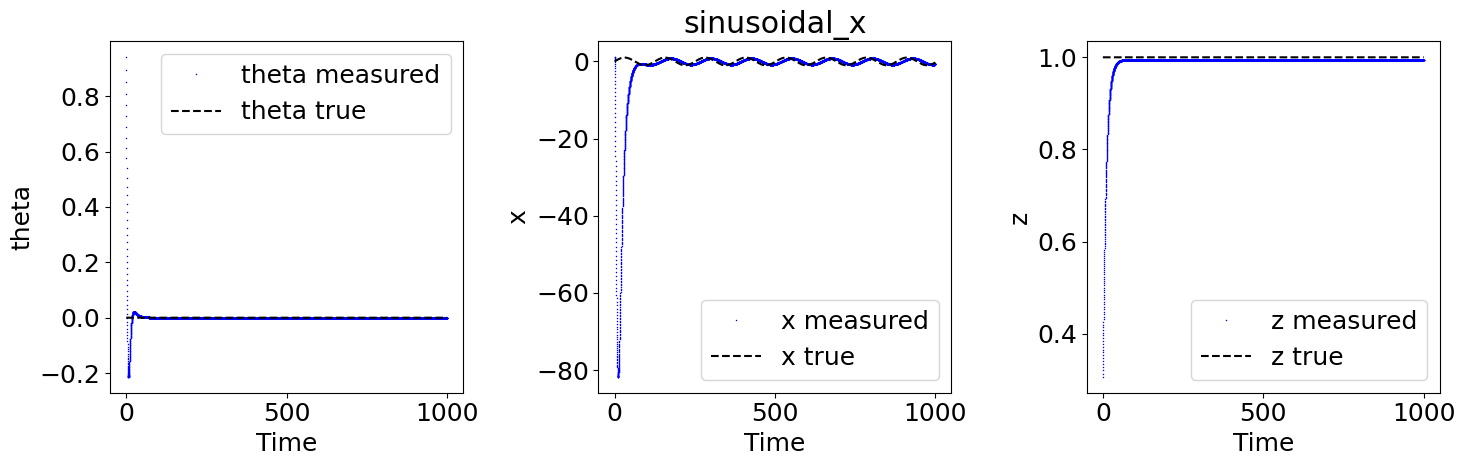

In [9]:
fig, axes = plt.subplots(len(simulated_states), 3, figsize=(15, 5*len(simulated_states)))
axes = (ax for ax in axes.ravel())

for trajectory_name, trajectory in trajectories.items():
    theta_des, x_des, z_des = trajectory(time)
    
    ax = next(axes)
    plot_tme(time, theta_des, simulated_states[trajectory_name][1], ax=ax, label_var='theta')
    
    ax = next(axes)
    plot_tme(time, x_des, simulated_states[trajectory_name][3], ax=ax, label_var='x')
    ax.set_title(trajectory_name)
    
    ax = next(axes)
    plot_tme(time, z_des, simulated_states[trajectory_name][5], ax=ax, label_var='z')
    
fig.tight_layout()

here, every row represents a particular trajectory.
\
\
\
### estimating observability of the model with varied trajectories and measurement matrix
this might take a while

In [10]:
sample_n = 10
sample_points = np.linspace(0, len(time), sample_n, endpoint=False).astype(int)

observability_values = np.zeros((len(simulated_states), len(O_collection), len(sample_points)))
for tr, state_values in simulated_states.items():    # for all trajectories
    for j,bigO in enumerate(O_collection):  # for all observability matrices
        print(f"==> {tr} and h_{j}")
        afunc = lambda i: bigO.subs(dict(zip(state, state_values[:, i]))).rank()
        
        values = np.array(list(map(afunc, sample_points)))
        observability_values[list(trajectories.keys()).index(tr), O_collection.index(bigO)] = values
        

==> sinusoidal_x and h_0
==> sinusoidal_x and h_1
==> sinusoidal_x and h_2
==> sinusoidal_x and h_3
==> sinusoidal_x and h_4
==> sinusoidal_x and h_5
==> sinusoidal_x and h_6
==> sinusoidal_x and h_7
==> sinusoidal_x and h_8
==> sinusoidal_x and h_9


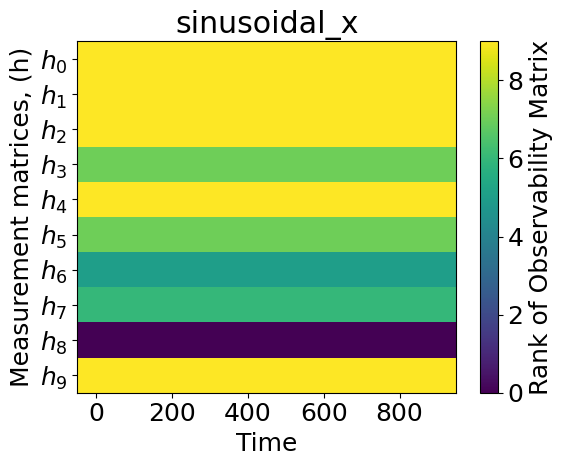

In [11]:
fig, axes = plt.subplots(len(trajectories), 1, figsize=(6, 5*len(trajectories)))
axes = (ax for ax in np.atleast_2d(axes).ravel())

for i, tr in enumerate(trajectories):
    ax = next(axes)
    k = ax.pcolormesh(time[sample_points], range(len(O_collection)), observability_values[i], shading='auto', cmap='viridis')
    colorbar = plt.colorbar(k, ax=ax)
    ax.set_title(tr)
    ax.set_ylabel("Measurement matrices, (h)")
    ax.set_xlabel("Time")
    ax.set_yticks(range(len(O_collection)), labels=[r'$h_{}$'.format(i) for i in range(len(O_collection))][::-1] )
    colorbar.set_label("Rank of Observability Matrix")
    
fig.tight_layout()

for current model and measurement function (h), observability does not change with time. I may have to change the model or measurement function to something eles so that the system's observability is time variant. it would make the analysis more interesting
\
\
\
one thing to note here: for some reason, the rank of observability matrix for the last few measurements does not match with the rank calculated directly (static observability of different measurements). 

# Emperical observability analysis

In [76]:
sampling_n = 10
window_size = 10
args = (sinusoidal_x, h1, state)

x0 = np.random.rand(6) 
sim_time = np.linspace(0, 1000, 100)
state_value, output_y = drone.simulate(x0, sim_time, *args)

crb_diags = []
cn_values = []
t0_windows = sim_time[::sampling_n]
window_dx = np.diff(sim_time)[0]
for t0_window in t0_windows:
    x0_window = state_value[:, sim_time == t0_window].reshape(-1)
    tsim_window = sim_time[np.logical_and(sim_time >= t0_window, sim_time < t0_window + window_size*window_dx)]

    bigO_mat, _, _ = empirical_observability_matrix(drone, x0_window, tsim_window, args=args, eps=1e-4)
    W = bigO_mat.T @ bigO_mat
    crb_diag = np.diag(np.linalg.inv(W + 1e-6*np.eye(W.shape[0])))
    crb_diags.append(crb_diag)
    if np.isnan(W).any():
        cn_values.append(np.nan)
    else:
        eig = np.linalg.eigvals(W)
        cn = np.max(eig)/np.min(eig)
        cn_values.append(cn)

    
crb_diags = np.vstack(crb_diags)

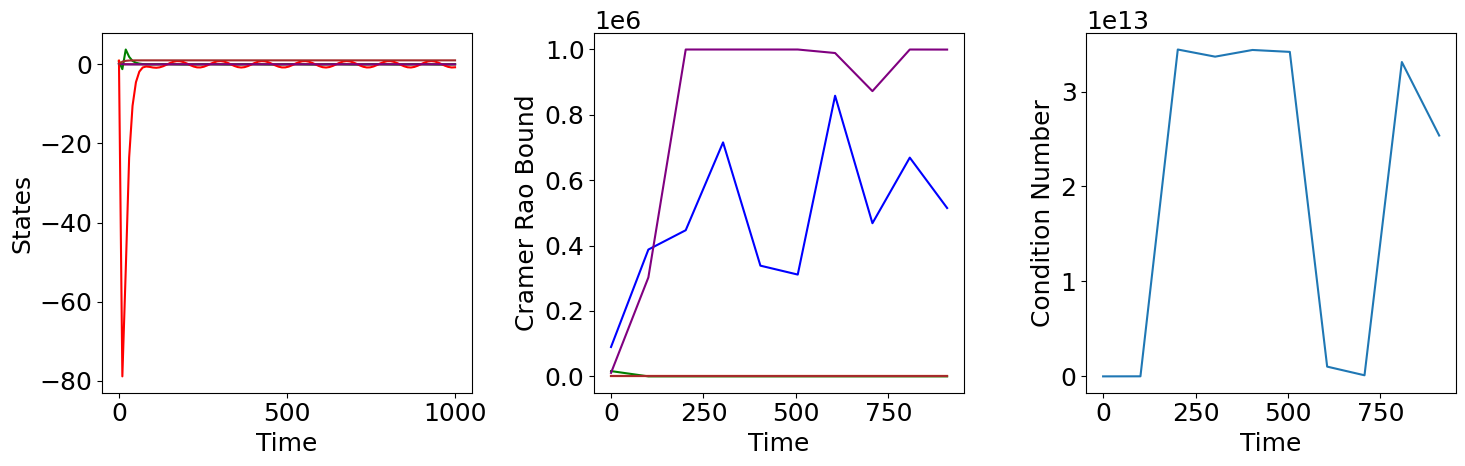

In [77]:
fig, [ax,bx,cx] = plt.subplots(1, 3, figsize=(15, 5))

colors = list(mcolors.TABLEAU_COLORS.keys())
colors = [name.split(':')[-1] for name in colors]

for i, xval in enumerate(range(state_value.shape[0])):
    ax.plot(sim_time, state_value[xval], label=f"state_{xval}", color=colors[i])
ax.set_ylabel('States')
ax.set_xlabel('Time')

for i, crb_diag in enumerate(crb_diags.T):
    bx.plot(t0_windows, crb_diag, label=f"state_{i}", color=colors[i])
bx.set_ylabel('Cramer Rao Bound')
bx.set_xlabel('Time')

cx.plot(t0_windows, cn_values)
cx.set_ylabel('Condition Number')
cx.set_xlabel('Time')

fig.tight_layout()

now lets try it on all the trajectories and all different measurement matrices
\
\
this might take a while

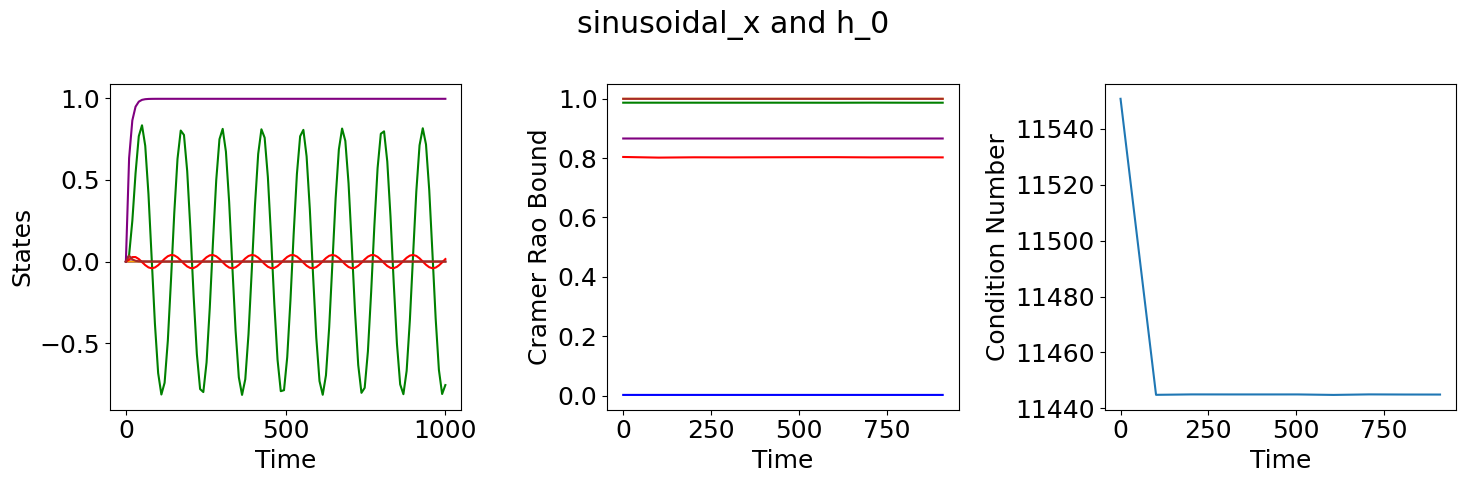

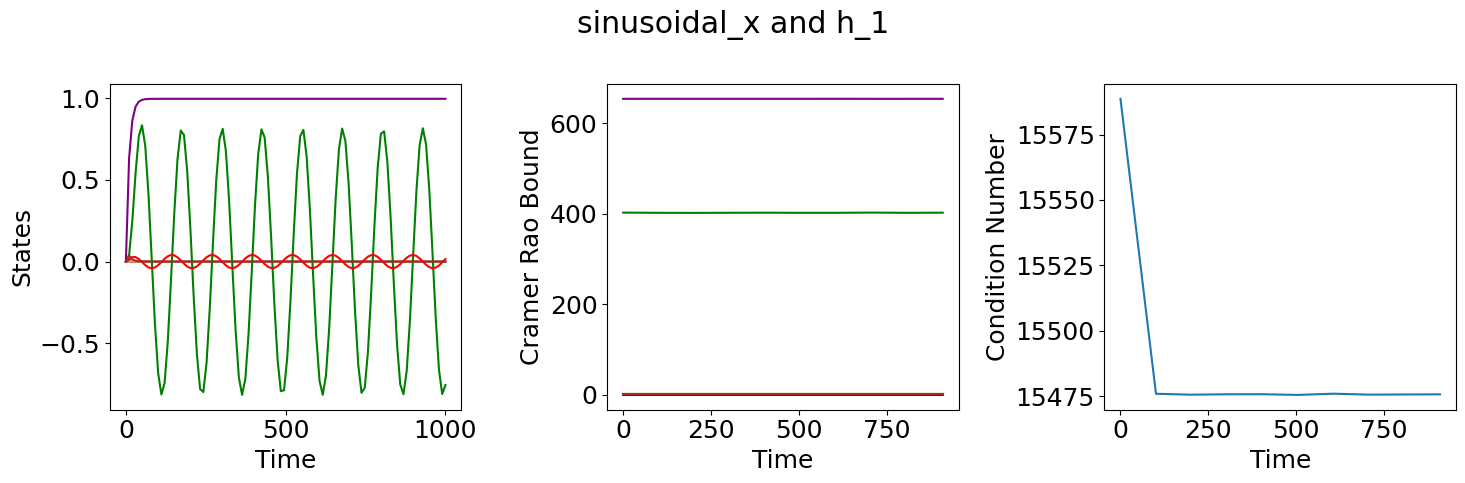

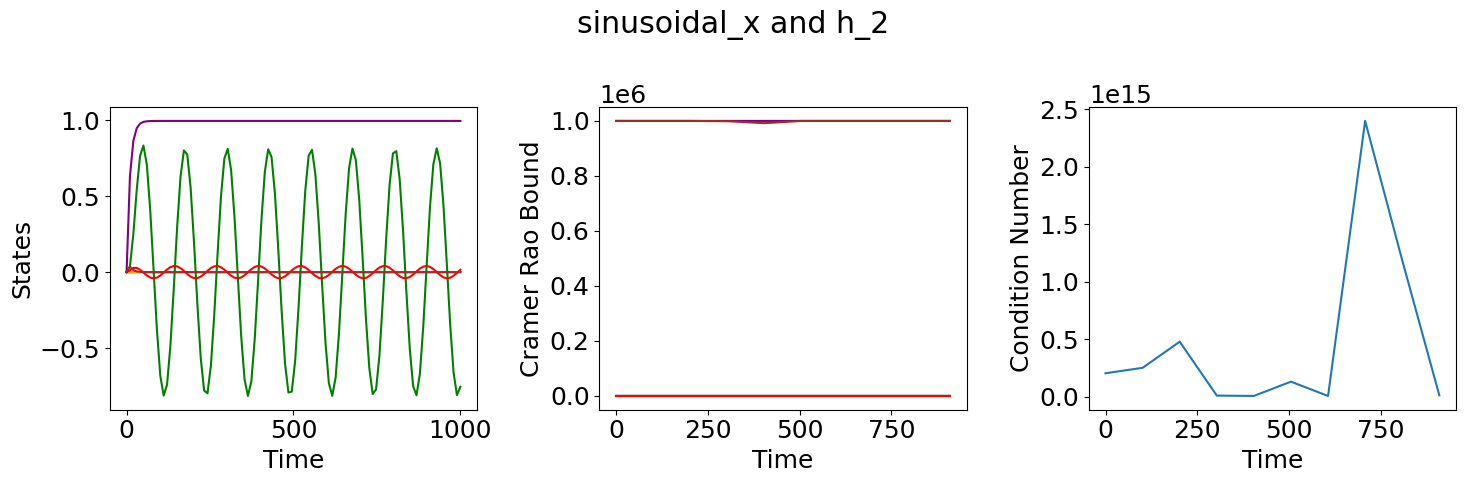

/home/tamzeed/Documents/nonlinear_estimation/Nonlinear_and_Data_Driven_Estimation/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/tamzeed/Documents/nonlinear_estimation/Nonlinear_and_Data_Driven_Estimation/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


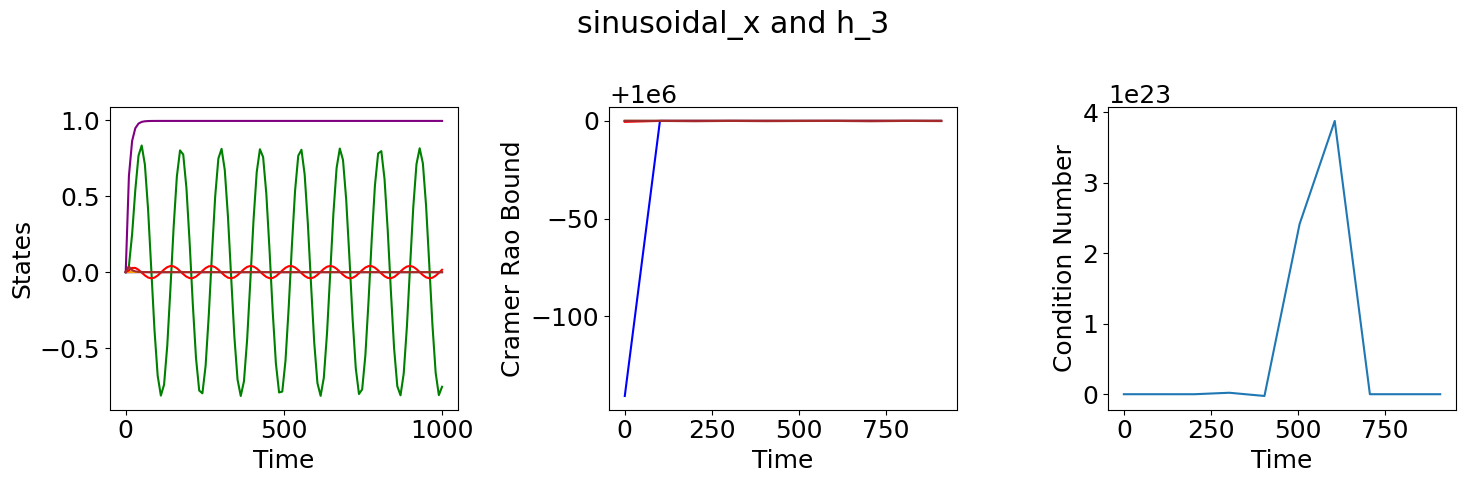

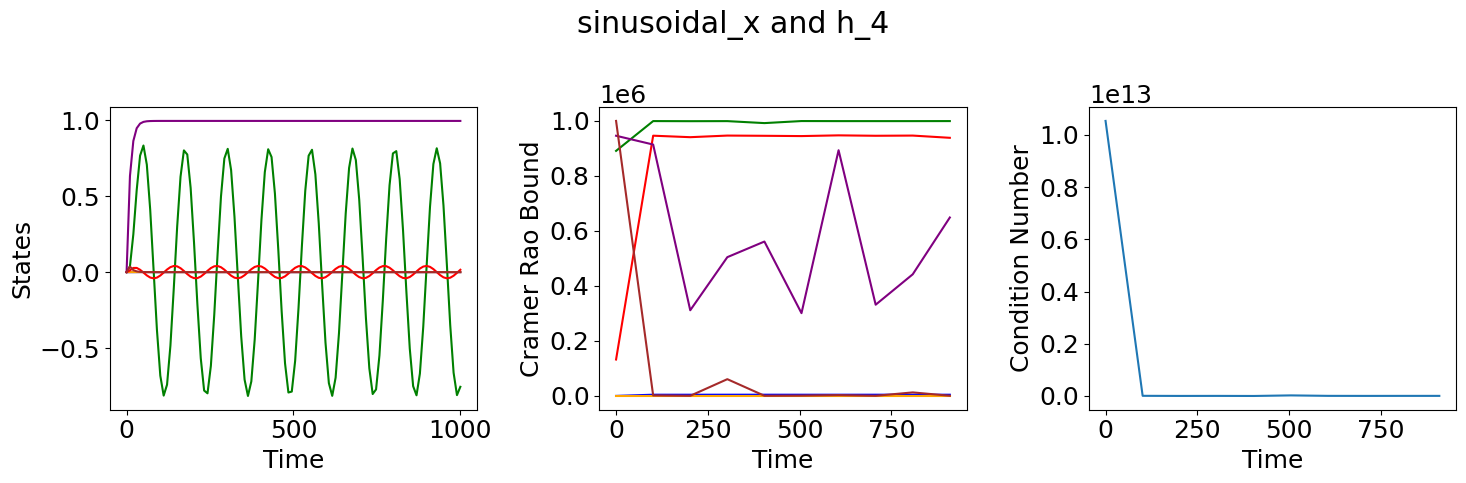

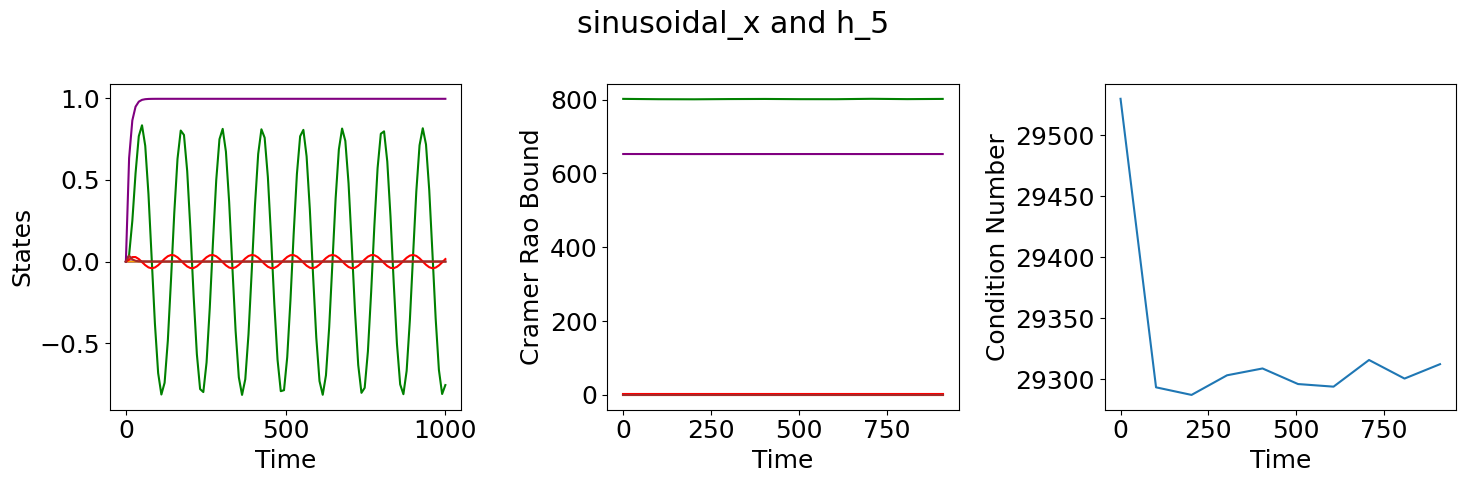

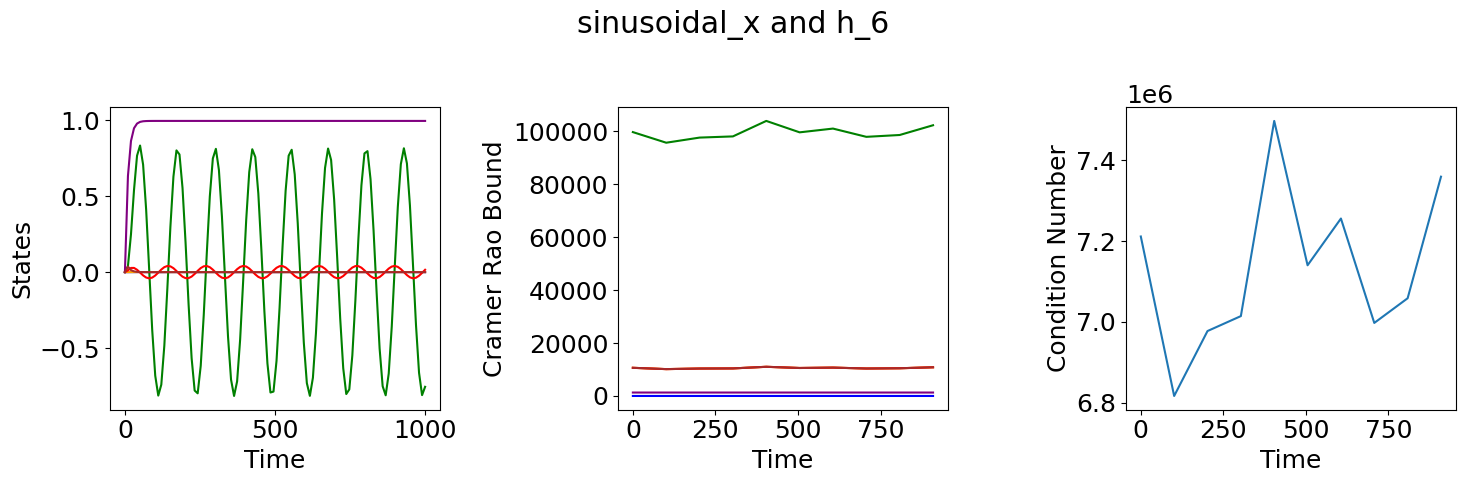

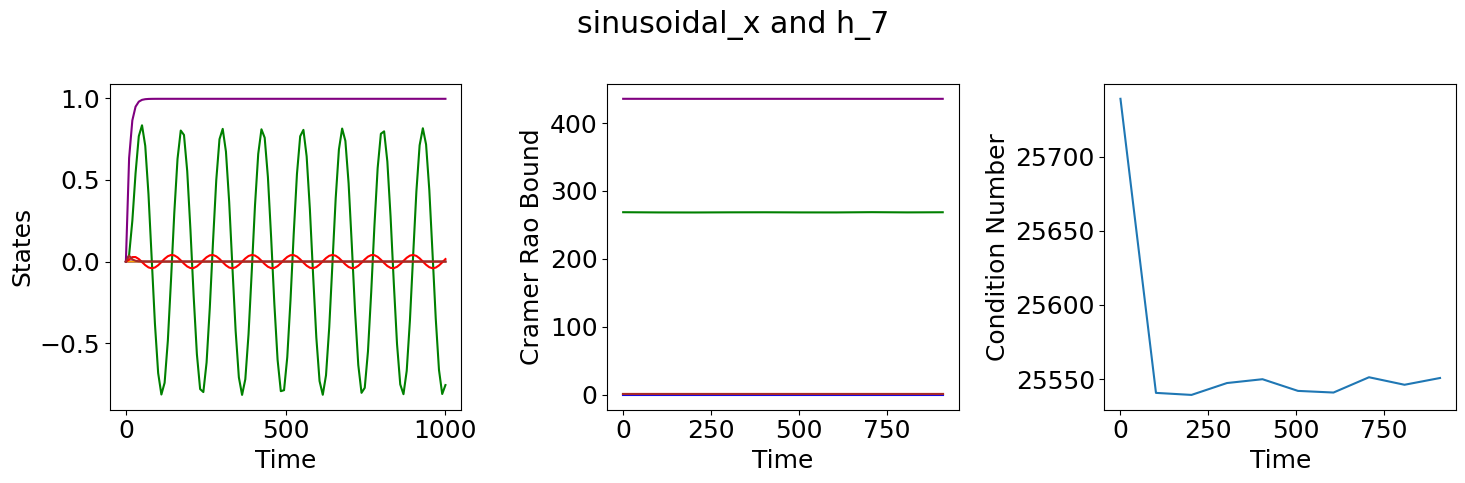

/home/tamzeed/Documents/nonlinear_estimation/Nonlinear_and_Data_Driven_Estimation/project/../Utility/emperical_observability.py:41: RuntimeWarning: invalid value encountered in cast
  deltay[:, k, :] = np.array(yplus - yminus) / (2 * eps)


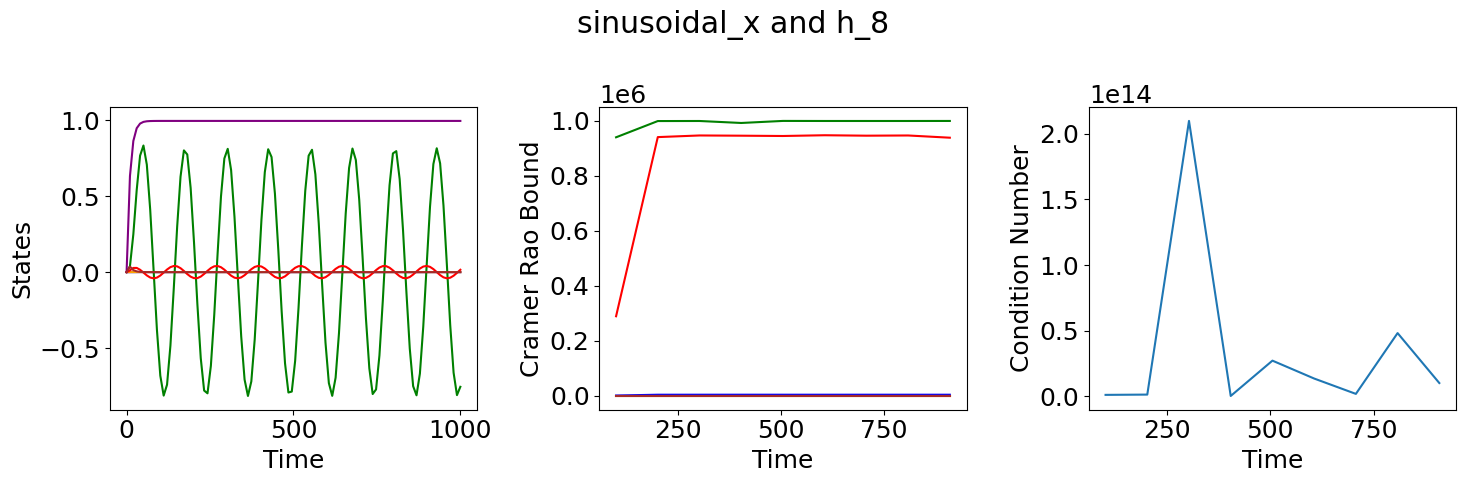

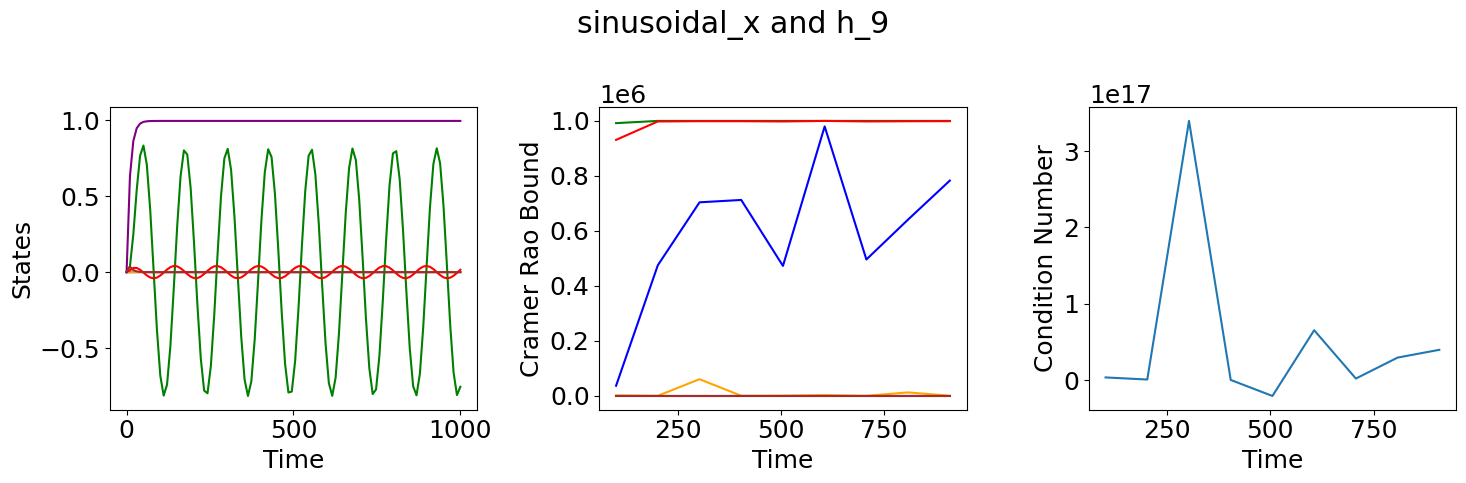

In [36]:
sampling_n = 10
window_size = 10

for i, tr in enumerate(trajectories.values()):
    for j, h in enumerate(h_collection):
        args = (tr, h, state)
        x0 = np.random.rand(6) * 0
        sim_time = np.linspace(0, 1000, 100)
        state_value, output_y = drone.simulate(x0, sim_time, *args)

        crb_diags = []
        cn_values = []
        t0_windows = sim_time[::sampling_n]
        window_dx = np.diff(sim_time)[0]
        for t0_window in t0_windows:
            x0_window = state_value[:, sim_time == t0_window].reshape(-1)
            tsim_window = sim_time[np.logical_and(sim_time >= t0_window, sim_time < t0_window + window_size*window_dx)]

            bigO_mat, _, _ = empirical_observability_matrix(drone, x0_window, tsim_window, args=args, eps=1e-4)
            W = bigO_mat.T @ bigO_mat
            crb_diag = np.diag(np.linalg.inv(W + 1e-6*np.eye(W.shape[0])))
            crb_diags.append(crb_diag)
            if np.isnan(W).any():
                cn_values.append(np.nan)
            else:
                eig = np.linalg.eigvals(W)
                cn = np.max(eig)/np.min(eig)
                cn_values.append(cn)

        crb_diags = np.vstack(crb_diags)
        fig, [ax,bx,cx] = plt.subplots(1, 3, figsize=(15, 5))

        colors = list(mcolors.TABLEAU_COLORS.keys())
        colors = [name.split(':')[-1] for name in colors]

        for ii, xval in enumerate(range(state_value.shape[0])):
            ax.plot(sim_time, state_value[xval], label=f"state_{xval}", color=colors[ii])
        ax.set_ylabel('States')
        ax.set_xlabel('Time')

        for ii, crb_diag in enumerate(crb_diags.T):
            bx.plot(t0_windows, crb_diag, label=f"state_{ii}", color=colors[ii])
        bx.set_ylabel('Cramer Rao Bound')
        bx.set_xlabel('Time')

        cx.plot(t0_windows, cn_values)
        cx.set_ylabel('Condition Number')
        cx.set_xlabel('Time')
        
        fig.suptitle(f"{list(trajectories.keys())[i]} and h_{j}")

        fig.tight_layout()
        plt.show()


# Estimation techniques
## extended kalman filter

\
\
first we have to simulate drone data like we have done above.

In [57]:
import ekf

In [64]:
# simulate data
# v = [0.01, 0.001, 0.2]
v = np.random.rand(9)/50
dt = 10    # large time step is used to reduce computation time

time = np.arange(0, 1000, dt)
drone = planer_drone()
true_xvals, true_yvals = drone.simulate(np.random.rand(6), time, sinusoidal_x, h0, state) 
noise = np.array( [np.random.normal(0, vi, true_yvals.shape[1]) for vi in v])
noisy_yvals = true_yvals + noise

# inputs
sys_input = [drone.control(true_xvals[:, i], time[i], sinusoidal_x) for i in range(true_xvals.shape[1])]
sys_input = np.vstack(sys_input).T

<Axes: xlabel='Time', ylabel='z'>

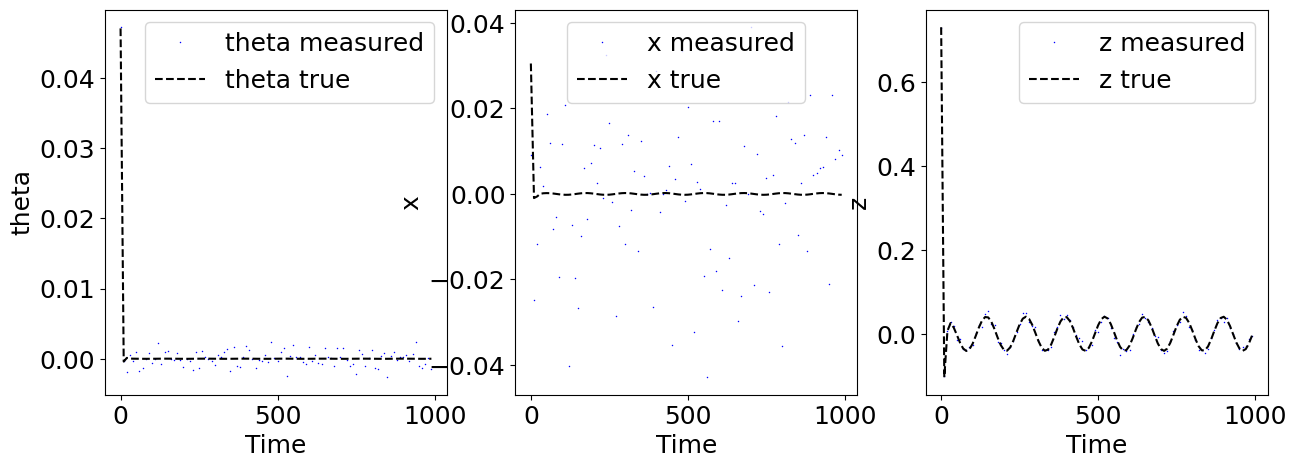

In [65]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = (ax for ax in axes.ravel())

ax = next(axes)
plot_tme(time, true_yvals[0], noisy_yvals[0], ax=ax, label_var='theta')

ax = next(axes)
plot_tme(time, true_yvals[1], noisy_yvals[1], ax=ax, label_var='x')

ax = next(axes)
plot_tme(time, true_yvals[2], noisy_yvals[2], ax=ax, label_var='z')

### initial conditions

In [168]:
x0 = np.atleast_2d(np.random.random(9)).T
P0 = 1000000*np.eye(9)

R = np.diag(np.array(v)**2)

Q = 5e-1*np.eye(9)

now we have to define our predicted model and measurement function. kalman filter will try to estimate the states of the model given this model dynamics and measurement function.

In [17]:
class MyModel():
    def __init__(self, h, state, dt=1):
        self.h = h
        self.sp_state = state
        self.dt = dt
        self.last_state = None
        
    def fd(self, state_x, u):
        try:
            thetadot, theta, xdot, x, zdot, z, beta1, beta2, beta3 = np.ravel(state_x).astype(float)
        except:
            print('got that error')
            state_x = sp.Matrix(state_x)
            state_x = state_x.subs('beta1', self.last_state[-3]).subs('beta2', self.last_state[-2]).subs('beta3', self.last_state[-1])
            thetadot, theta, xdot, x, zdot, z, beta1, beta2, beta3 = np.ravel(state_x).astype(float)

        self.last_state = state_x
        
        F, tau = np.ravel(u)
        I = 1/beta1
        m1 = -1/beta2
        m2 = 1/beta3
        m = np.mean([m1, m2])      # should have only one state for this one unknown parameter
        
        new_theta = theta + thetadot*self.dt
        new_thetadot = tau/I
        new_x = x + xdot*self.dt
        new_xdot = -F*np.sin(theta)/m
        new_z = z + zdot*self.dt
        new_zdot = (F*np.cos(theta)-m*9.8)/m
        
        new_x = np.atleast_2d([new_thetadot, new_theta, new_xdot, new_x, new_zdot, new_z, beta1, beta2, beta3]).T
        return new_x
    
    def hd(self, state_x, u):
        thetadot, theta, xdot, x, zdot, z, beta1, beta2, beta3 = np.ravel(state_x)
        y = self.h.subs(list(zip(self.sp_state, np.ravel(state_x))))
        return np.atleast_2d(y)
        

In [170]:
model = MyModel(h0, state, dt)
xhat, P, s = ekf.ekf(noisy_yvals, x0, model.fd, model.hd, Q, R, sys_input)

got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that error
got that e

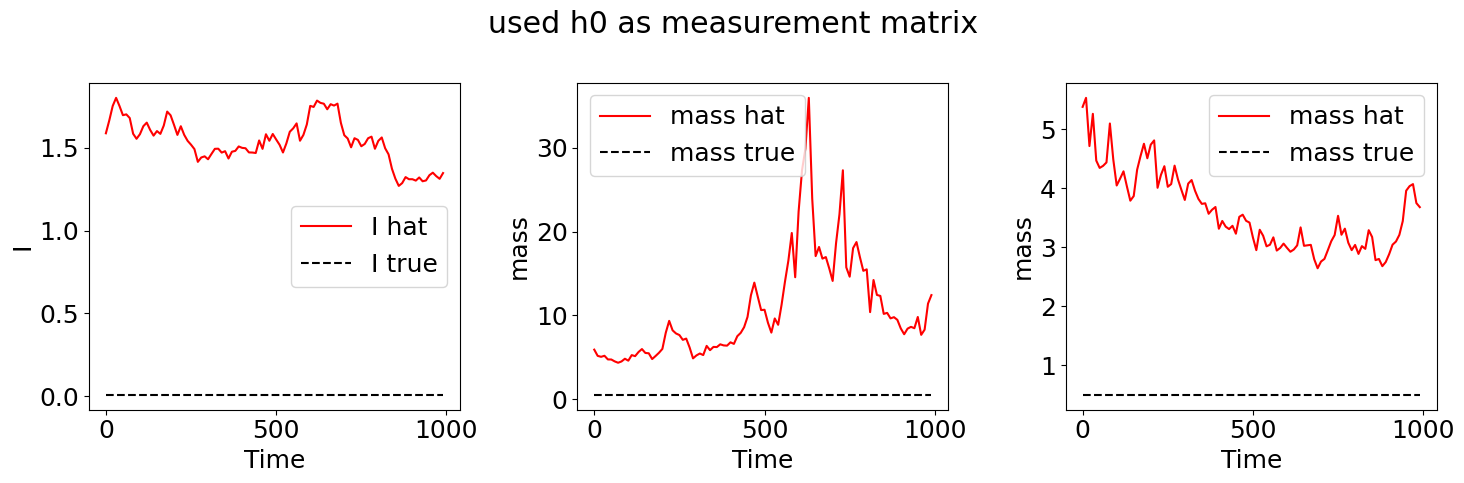

In [176]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = (ax for ax in axes.ravel())

ax = next(axes)
plot_tme(time, drone.I*np.ones_like(time), None, 1/xhat[-3], ax=ax, label_var='I')

ax = next(axes)
plot_tme(time, 0.5*np.ones_like(time), None, 1/xhat[-2], ax=ax, label_var='mass')

ax = next(axes)
plot_tme(time, 0.5*np.ones_like(time), None, 1/xhat[-1], ax=ax, label_var='mass')

fig.suptitle("used h0 as measurement matrix")
fig.tight_layout()

the above measurement function has direct measurements of the unknown parameters. still the estimator performs poorly. 
\
\
now we will try to estimate the states of the model without direct measurements of the unknown parameters. we will use the all other measurement functions except the first one

==> h_1


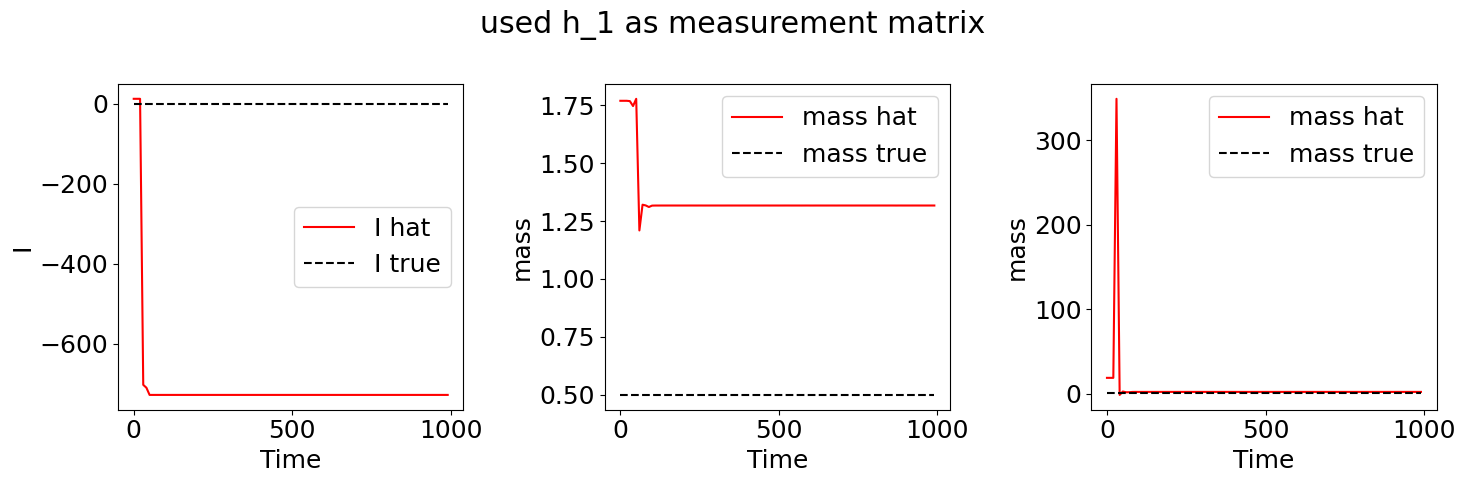

==> h_2


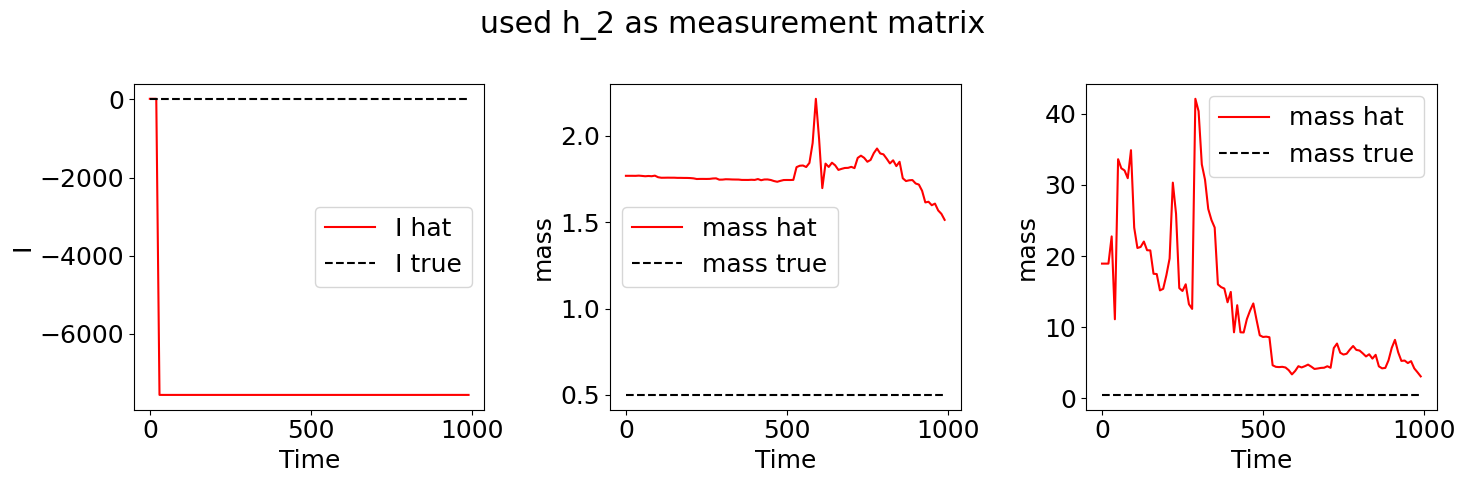

==> h_3


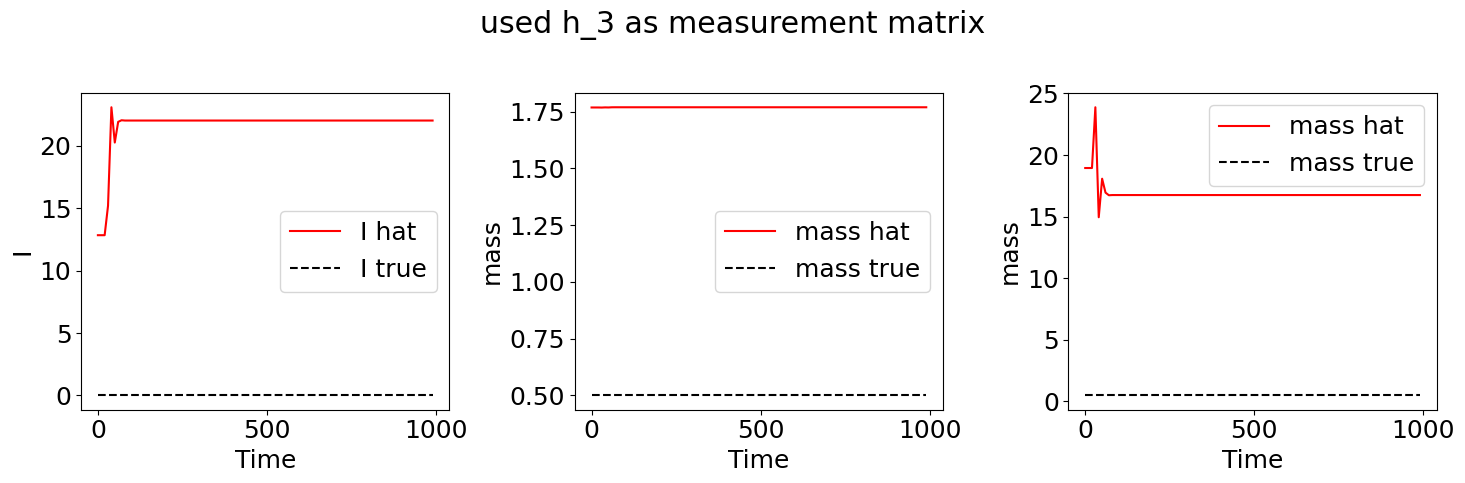

==> h_4


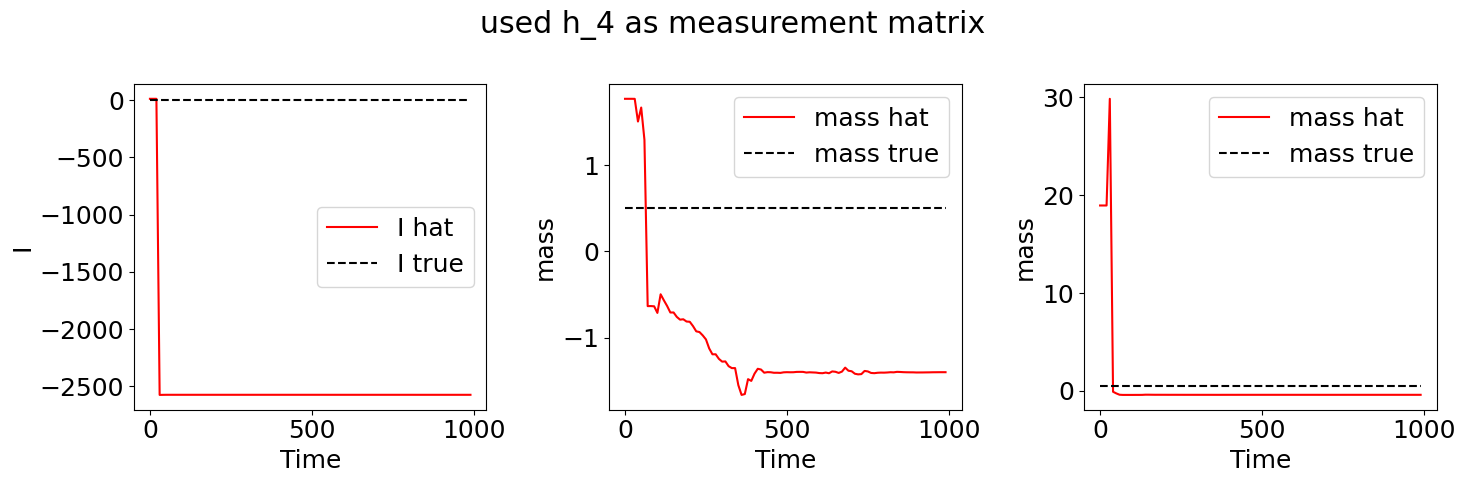

==> h_5


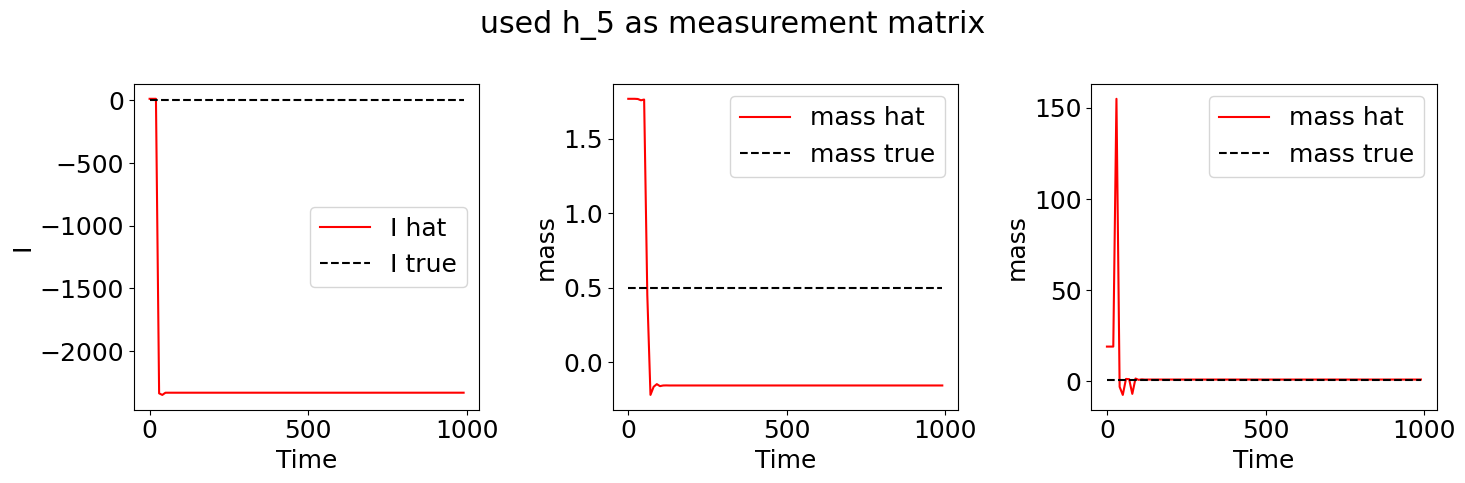

==> h_6


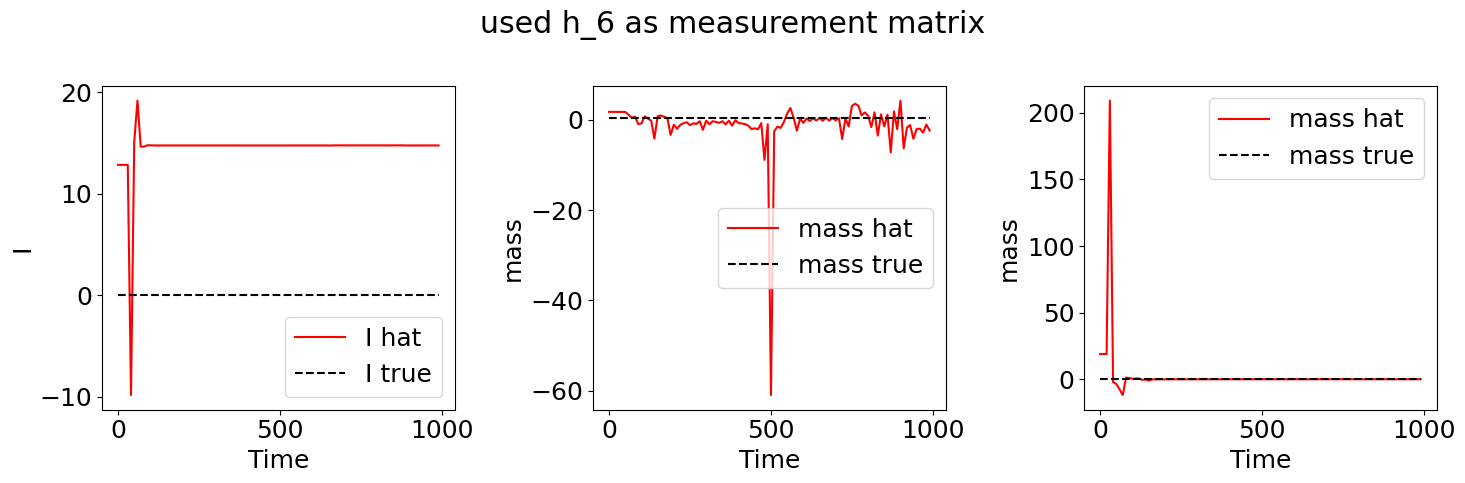

==> h_7


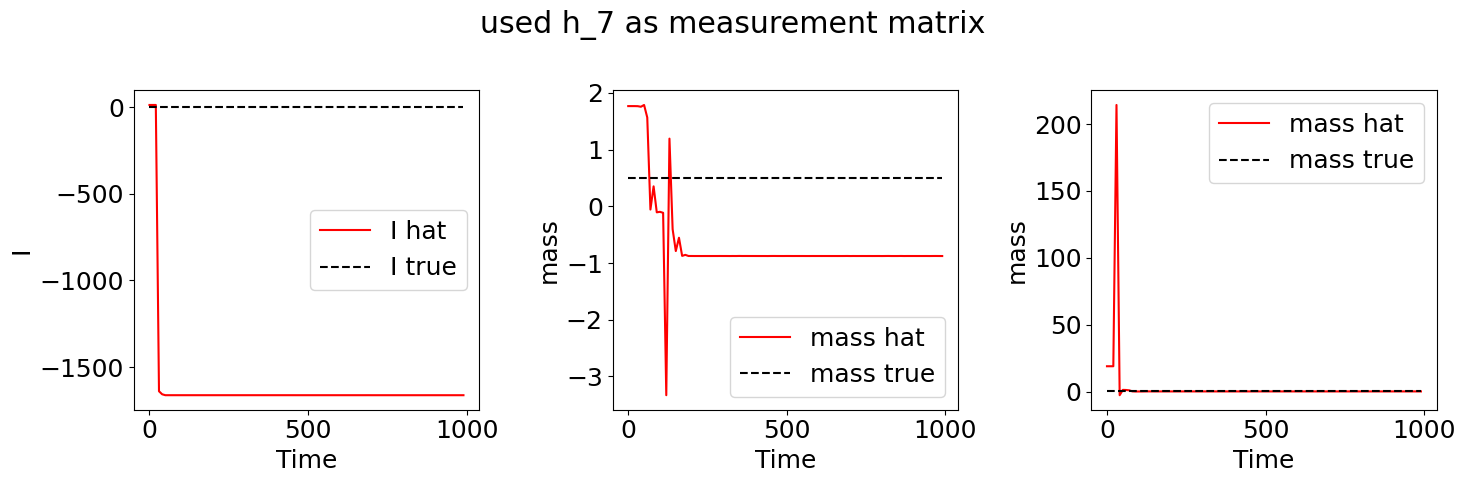

==> h_8


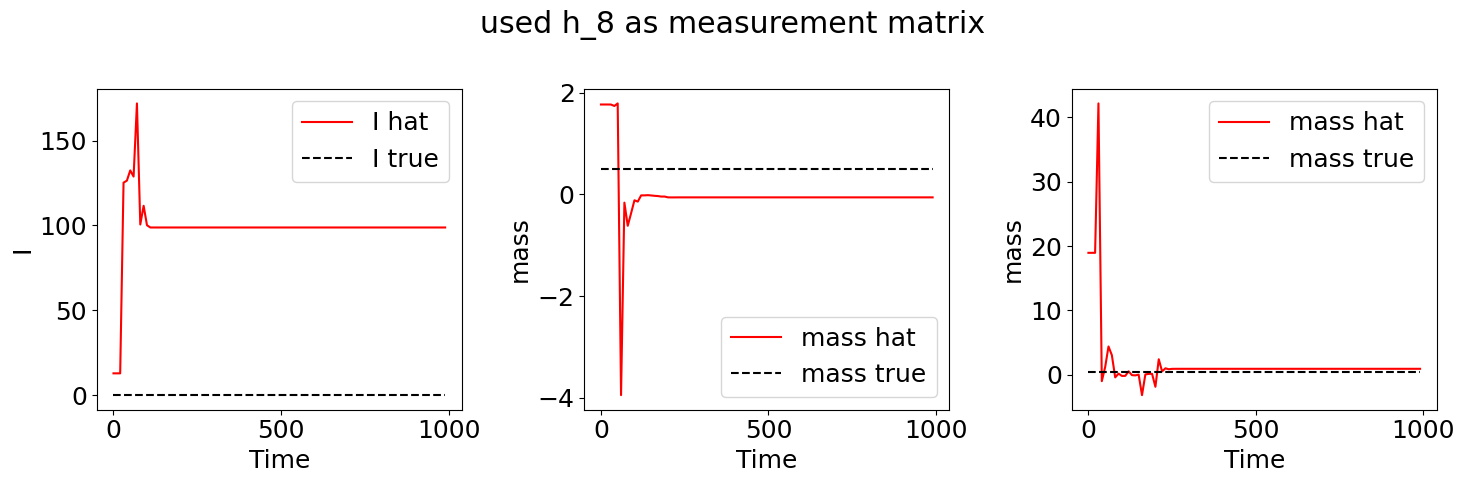

==> h_9


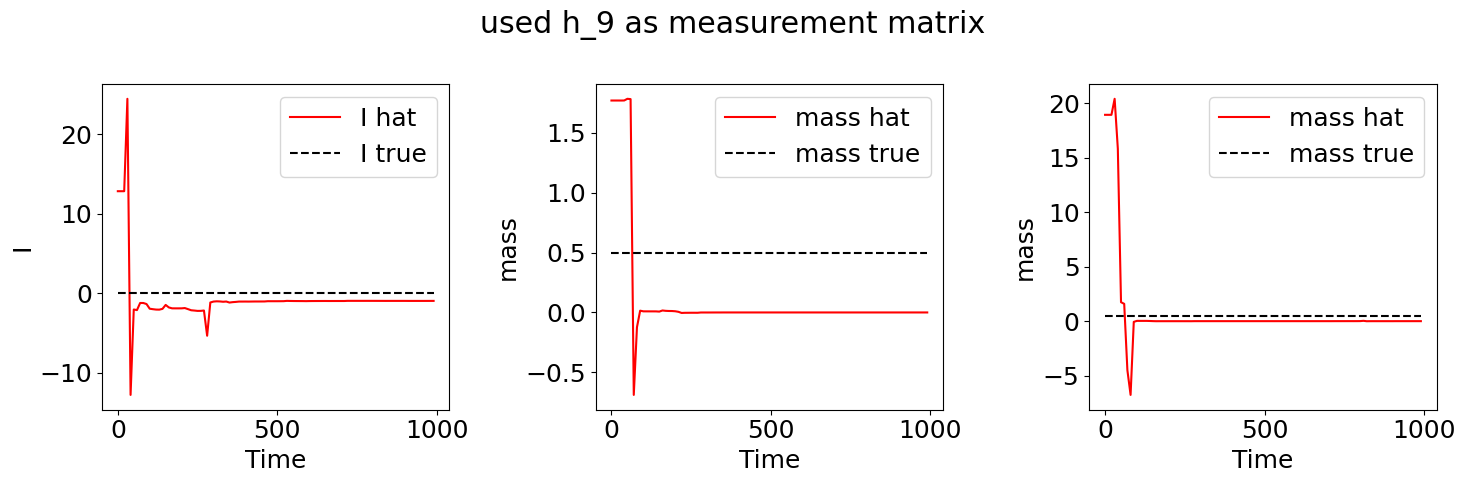

In [41]:
# simulate data
dt = 10    # large time step is used to reduce computation time
x0 = np.atleast_2d(np.random.random(9)).T 

for i, h in enumerate(h_collection[1:]):
    print(f"==> h_{i+1}")
    try:
        time = np.arange(0, 1000, dt)
        drone = planer_drone()
        true_xvals, true_yvals = drone.simulate(np.random.rand(6), time, sinusoidal_x, h, state) 
        v = np.random.rand(h.shape[0])/50
        noise = np.array( [np.random.normal(0, vi, true_yvals.shape[1]) for vi in v])
        noisy_yvals = true_yvals + noise

        # inputs
        sys_input = [drone.control(true_xvals[:, i], time[i], sinusoidal_x) for i in range(true_xvals.shape[1])]
        sys_input = np.vstack(sys_input).T

        P0 = 1000000*np.eye(9)

        R = np.diag(np.array(v)**2)
        Q = 5e-1*np.eye(9)
        
        model = MyModel(h, state, dt)
        xhat, P, s = ekf.ekf(noisy_yvals, x0, model.fd, model.hd, Q, R, sys_input)
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes = (ax for ax in axes.ravel())

        ax = next(axes)
        plot_tme(time, drone.I*np.ones_like(time), None, 1/xhat[-3], ax=ax, label_var='I')
        ax = next(axes)
        plot_tme(time, 0.5*np.ones_like(time), None, 1/xhat[-2], ax=ax, label_var='mass')
        ax = next(axes)
        plot_tme(time, 0.5*np.ones_like(time), None, 1/xhat[-1], ax=ax, label_var='mass')
        fig.suptitle(f"used h_{i+1} as measurement matrix")
        fig.tight_layout()
        plt.show()
    except Exception as e:
        print(e)
        continue

unfortunately, from these estimations, the relationship between state estimation and observability is not yet super clear. I still have to find a way to improve this estimation. 

In [55]:
for h in G_collection:
    sp.print_latex(h)
    print(",")

\left[\begin{matrix}0\\- g\\\theta\\x\\\beta_{3}\\\dot{\theta}\\\beta_{1}\\\beta_{2}\\z\\\dot{x}\\\dot{z}\end{matrix}\right]
,
\left[\begin{matrix}0\\- g\\\theta\\x\\\beta_{3}\\\dot{\theta}\\\beta_{1}\\\beta_{2}\\z\\\dot{x}\\\dot{z}\end{matrix}\right]
,
\left[\begin{matrix}0\\\theta\\x\\\dot{x}\\\dot{\theta}\\\beta_{1}\\\beta_{2}\end{matrix}\right]
,
\left[\begin{matrix}0\\\beta_{1} x z\\\theta x z\\\beta_{2} \theta z + \beta_{3} \theta x\\\dot{\theta} x z + \dot{x} \theta z + \dot{z} \theta x\\\dot{\theta} \left(\dot{x} z + \dot{z} x\right) + \dot{x} \left(\dot{\theta} z + \dot{z} \theta\right) + \dot{z} \left(\dot{\theta} x + \dot{x} \theta\right) - g \theta x\end{matrix}\right]
,
\left[\begin{matrix}0\\\dot{x} z + \dot{z} x\\x z\\\theta\\\beta_{2} z + \beta_{3} x\\\dot{\theta}\\2 \dot{x} \dot{z} - g x\\\beta_{1}\end{matrix}\right]
,
\left[\begin{matrix}0\\- g\\\theta\\\beta_{3}\\\dot{\theta}\\\beta_{1}\\x + z\\z\\\beta_{2} + \beta_{3}\\\dot{x} + \dot{z}\\\dot{z}\end{matrix}\right]
,